### 📌 1. Chargement des bibliothèques et fonctions utilitaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             roc_auc_score, 
                             classification_report, 
                             confusion_matrix, 
                             roc_curve, 
                             auc)
from multiprocessing import cpu_count

# Fonction pour évaluer les modèles
def evaluate_model(y_true, y_pred, y_probs, model_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_probs)
    }
    print(f"\n=== Rapport de classification pour {model_name} ===\n")
    print(classification_report(y_true, y_pred))
    
    # Matrice de confusion
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    
    return metrics

### 📌 2. Chargement et préparation des données

In [2]:
df = pd.read_csv("hmeq.csv")
columnNames = pd.Series(df.columns.values)

In [3]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
df.shape

(5960, 13)

In [5]:
# descriptive statistics
description = df.describe(
    include="all"
)  # to get the basic summary of all the numeric columns and frequency distribution of all the categorical columns.
description

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708,5681,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,NaN,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,DebtCon,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,3928,2388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,NaN,NaN,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,NaN,NaN,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141


In [6]:
data_types = df.dtypes  # to print data types for each variable
data_types

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [7]:
MissingData = (
    df.isnull().sum().rename_axis("Variables").reset_index(name="Missing Values")
)  # the isnull() returns 1 if the value is null
MissingData

,Variables,Missing Values
0,BAD,0
1,LOAN,0
2,MORTDUE,518
3,VALUE,112
4,REASON,252
5,JOB,279
6,YOJ,515
7,DEROG,708
8,DELINQ,580
9,CLAGE,308


In [8]:
# Gestion des valeurs manquantes
num_cols = df.select_dtypes(include=["number"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1.0,1500.0,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0.0,88900.0,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0.0,89000.0,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0.0,89200.0,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0.0,89800.0,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [9]:
MissingData1 = (
    df.isnull().sum().rename_axis("Variables").reset_index(name="Missing Values")
)  # the isnull() returns 1 if the value is null
MissingData1

,Variables,Missing Values
0,BAD,0
1,LOAN,0
2,MORTDUE,0
3,VALUE,0
4,REASON,0
5,JOB,0
6,YOJ,0
7,DEROG,0
8,DELINQ,0
9,CLAGE,0


In [10]:
# Création de nouvelles variables
df['Mortgage_Ratio'] = df['MORTDUE'] / df['VALUE']
df['Loan_Value_Ratio'] = df['LOAN'] / df['VALUE']
df['Default_Ratio'] = df['DEROG'] + df['DELINQ']
df['Adjusted_Debt_Ratio'] = df['DEBTINC'] / (df['YOJ'] + 1)

Exploratory Data Analysis (EDA)
==

**Univariate Analysis**

In this analysis we examine each variable individually. For categorical features we can use bar plots which calculates the total count of each category in a particular variable. For numerical features we can use histograms or probability density plots to look at the distribution of the variable.

<Axes: title={'center': 'BAD'}, xlabel='BAD'>

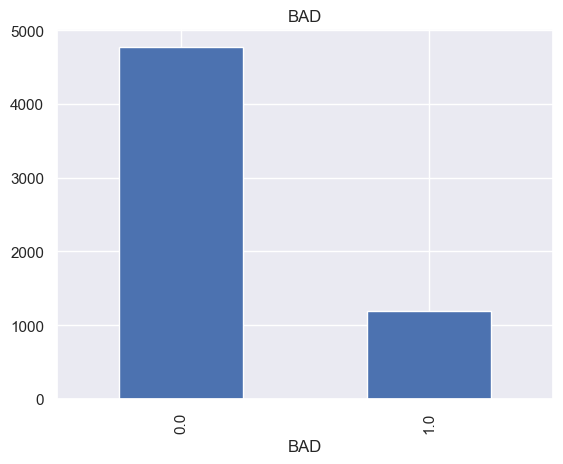

In [11]:
# Frequency distribution of target variable "BAD" and visualizing the target variable
df["BAD"].value_counts().plot.bar(title="BAD")

<Axes: title={'center': 'REASON'}, xlabel='REASON'>

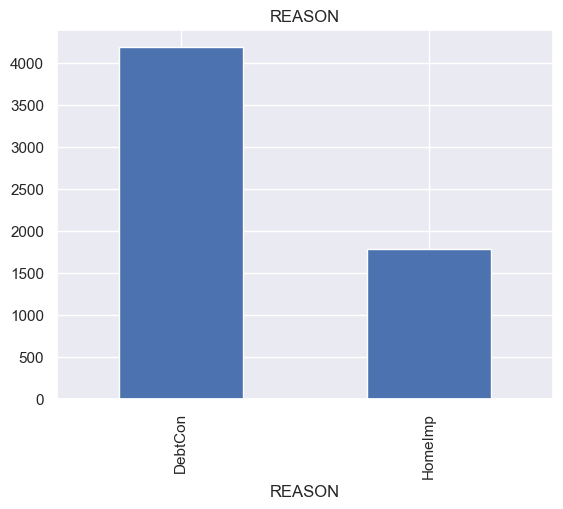

In [12]:
# visualizing the categorical variable REASON
REASON_count = (
    df["REASON"].value_counts().rename_axis("REASON").reset_index(name="Total Count")
)
df["REASON"].value_counts().plot.bar(title="REASON")

### 📌 3. Entraînement et évaluation des modèles classiques

<Axes: title={'center': 'JOB'}, xlabel='JOB'>

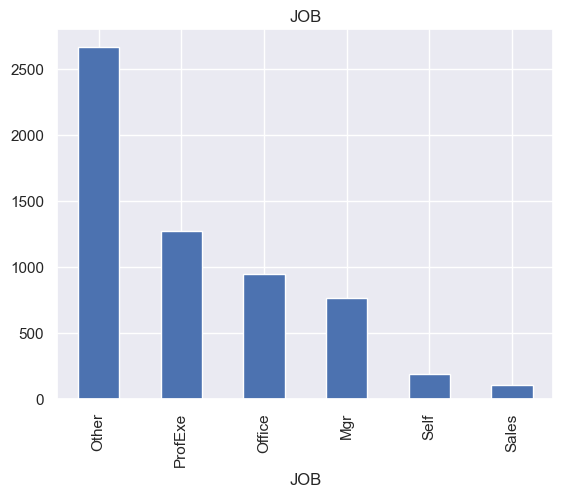

In [13]:
# visualizing the categorical variable JOB
JOB_count = df["JOB"].value_counts().rename_axis("JOB").reset_index(name="Total Count")
df["JOB"].value_counts().plot.bar(title="JOB")

<Axes: xlabel='CLNO', ylabel='Count'>

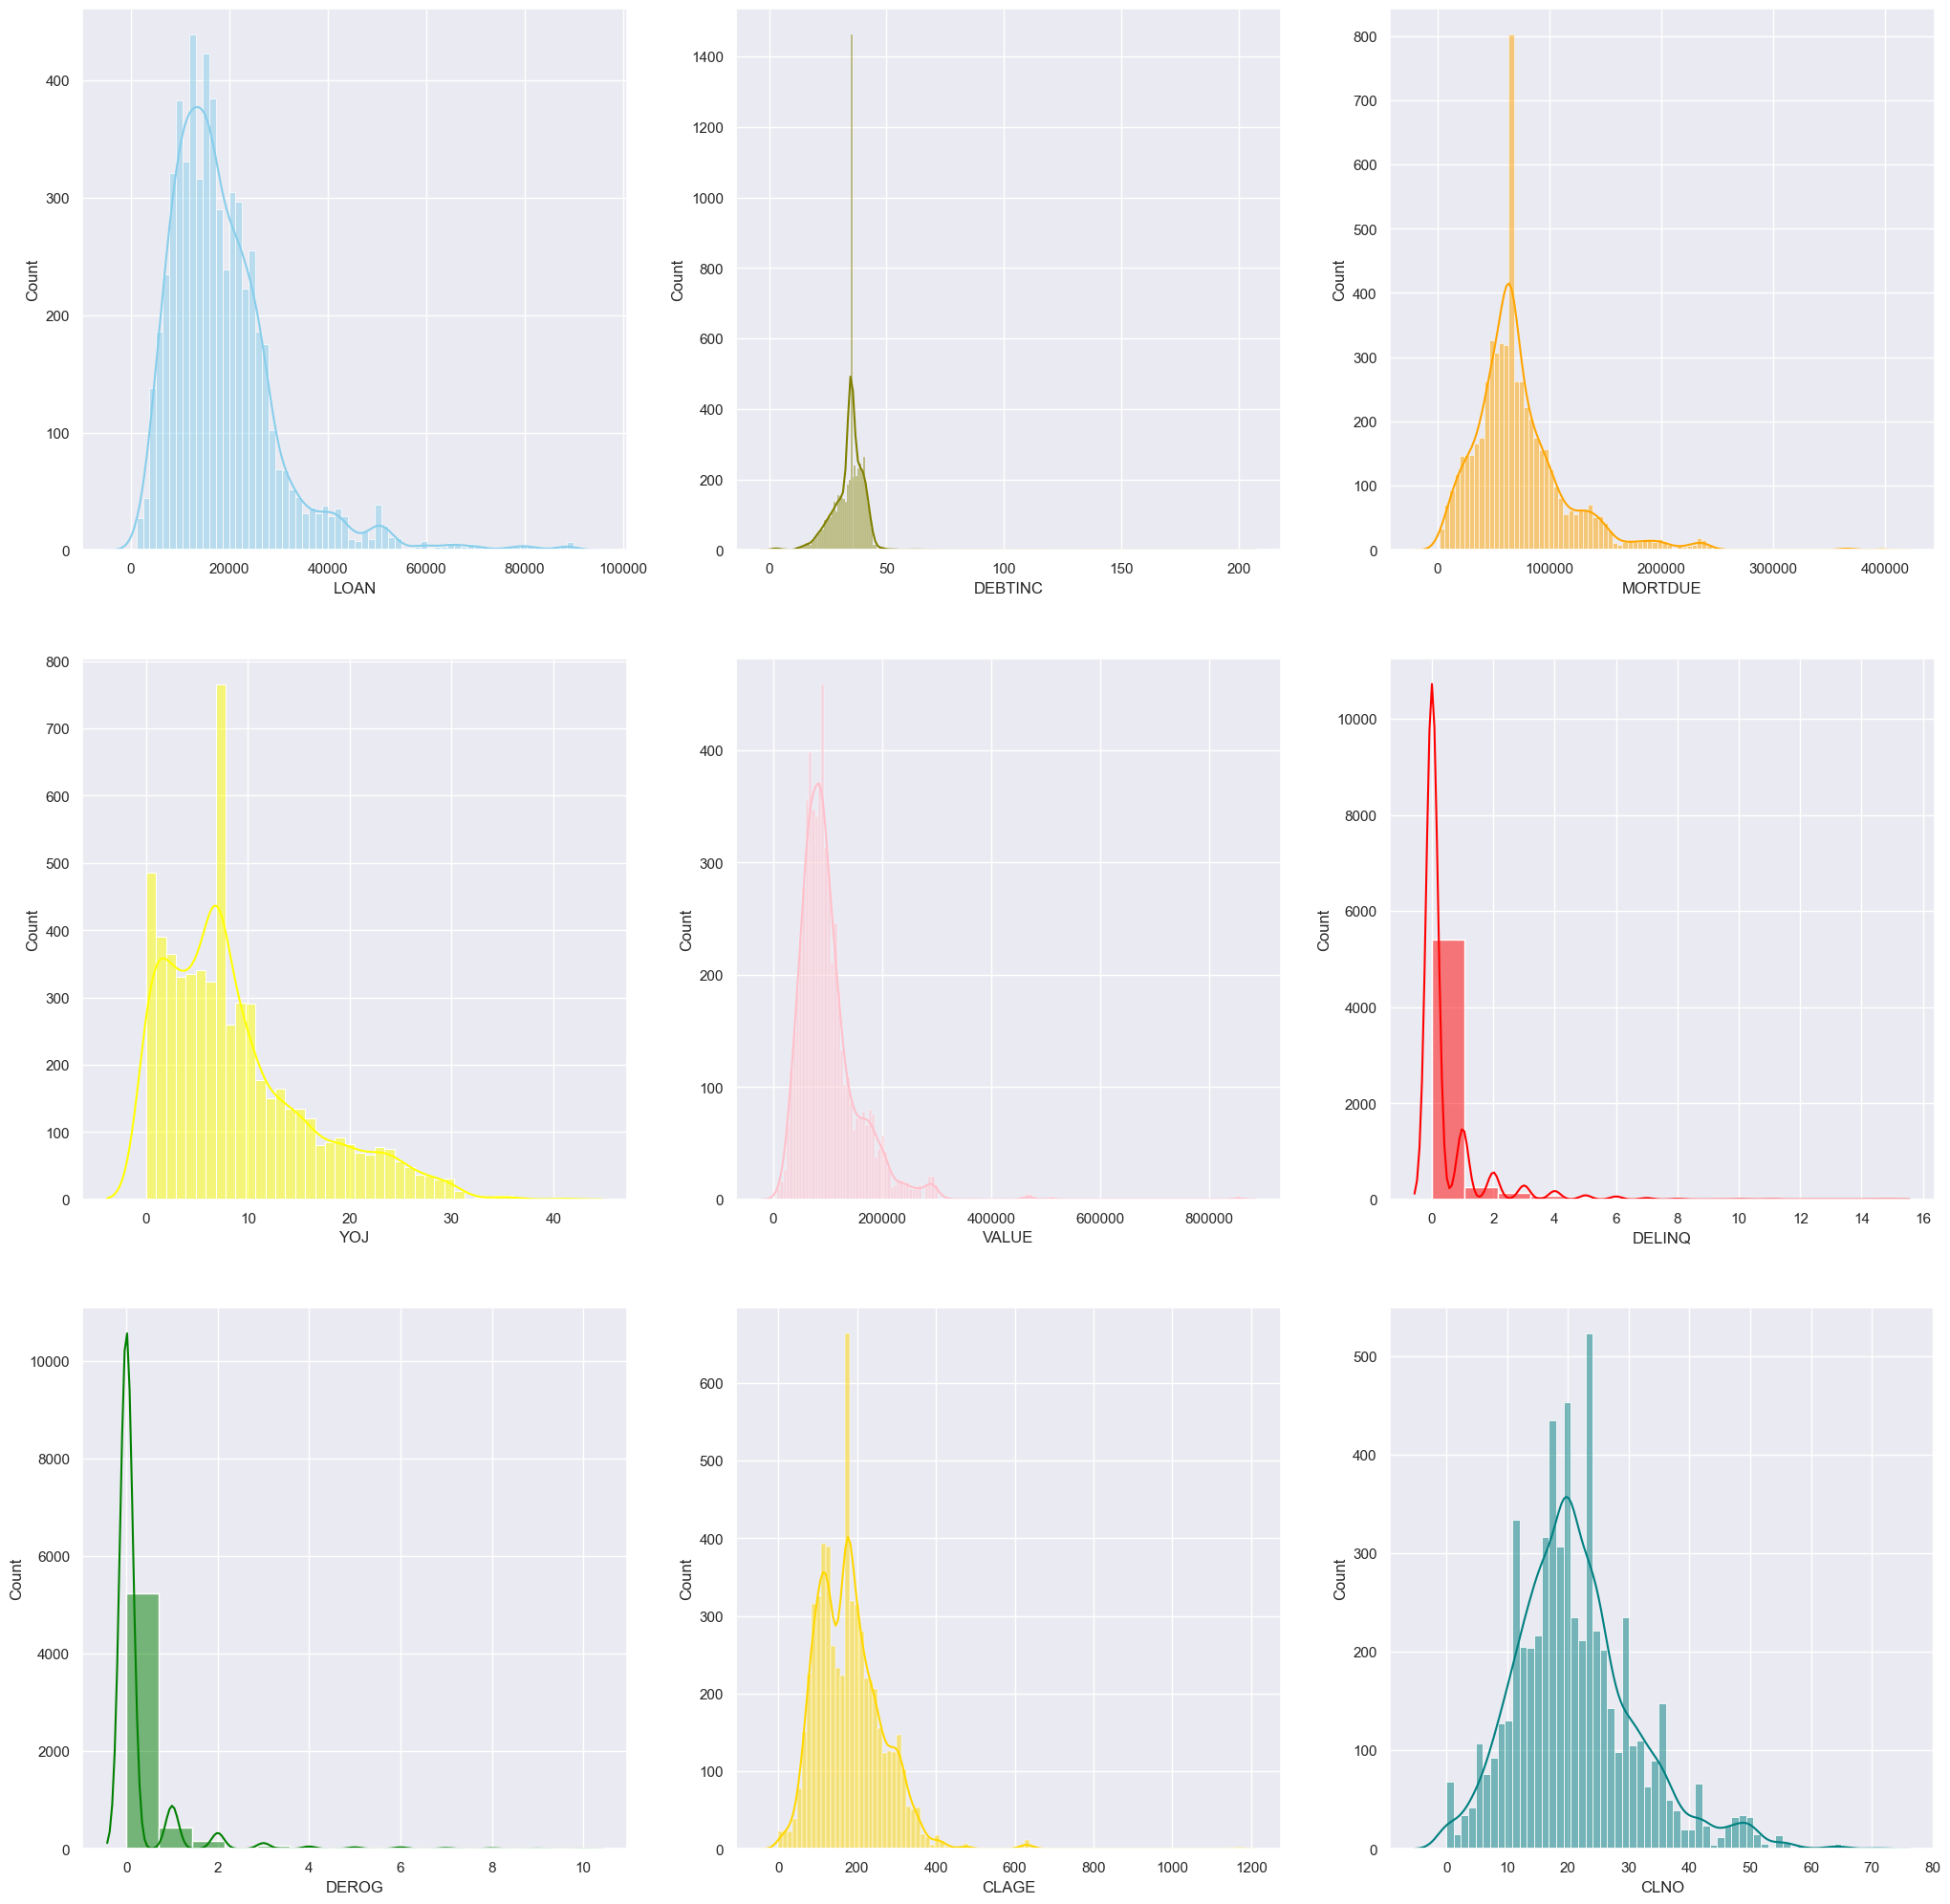

In [14]:
# visualizing numeric variables using seaborn
f, axes = plt.subplots(3, 3, figsize=(25, 25))
sns.histplot(df["LOAN"], color="skyblue", ax=axes[0, 0], kde=True, kde_kws=dict(cut=3))
# sns.histplot(df["LOAN"], color="skyblue", ax=axes[0, 0], kde=True, kde_kws=dict(cut=6))
sns.histplot(df["DEBTINC"], color="olive", ax=axes[0, 1], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["MORTDUE"], color="orange", ax=axes[0, 2], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["YOJ"], color="yellow", ax=axes[1, 0], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["VALUE"], color="pink", ax=axes[1, 1], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["DELINQ"], color="red", ax=axes[1, 2], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["DEROG"], color="green", ax=axes[2, 0], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["CLAGE"], color="gold", ax=axes[2, 1], kde=True, kde_kws=dict(cut=3))
sns.histplot(df["CLNO"], color="teal", ax=axes[2, 2], kde=True, kde_kws=dict(cut=3))



Bivariate Analysis

In this analysis we explore the relationship of each variable with respect to the target variable. We can also check our hypothesis using bivariate analysis.

Categorical and Target Variable Relationship


<Axes: title={'center': 'JOB vs BAD'}, xlabel='JOB'>

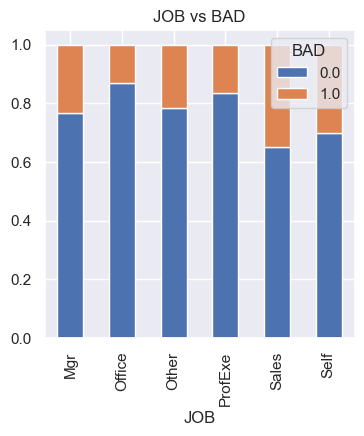

In [15]:
JOB = pd.crosstab(df["JOB"], df["BAD"])
JOB.div(JOB.sum(1).astype(float), axis=0).plot(
    kind="bar", stacked=True, title="JOB vs BAD", figsize=(4, 4)
)

<Axes: title={'center': 'REASON vs BAD'}, xlabel='REASON'>

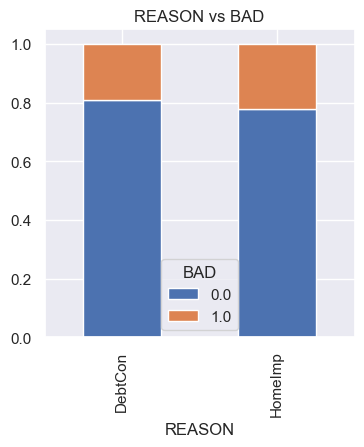

In [16]:
REASON = pd.crosstab(df["REASON"], df["BAD"])
REASON.div(REASON.sum(1).astype(float), axis=0).plot(
    kind="bar", stacked=True, title="REASON vs BAD", figsize=(4, 4)
)



Numeric and Target Variable Relationship

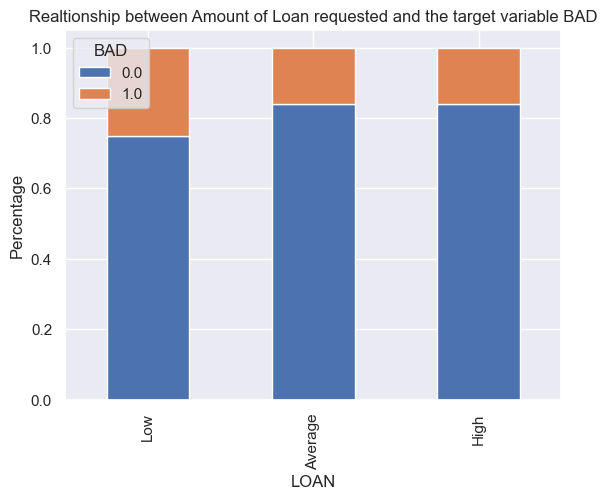

In [17]:
dfWithBin = df.copy()
bins = [0, 15000, 25000, 90000]
group = ["Low", "Average", "High"]
dfWithBin["LOAN_bin"] = pd.cut(df["LOAN"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["LOAN_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Realtionship between Amount of Loan requested and the target variable BAD",
)
plt.xlabel("LOAN")
P = plt.ylabel("Percentage")

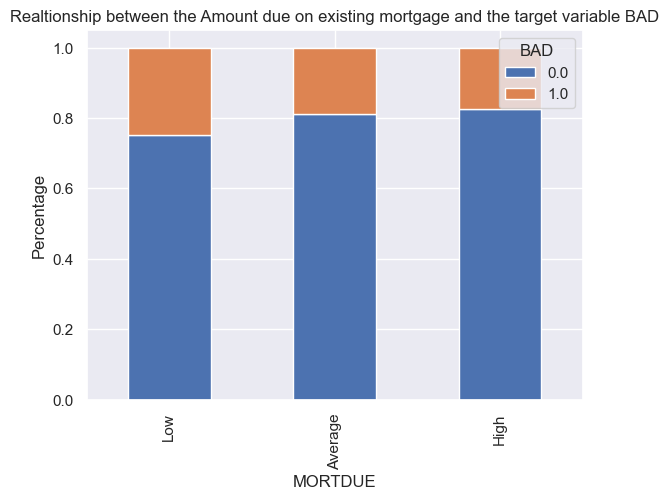

In [18]:
bins = [0, 47000, 92000, 400000]
group = ["Low", "Average", "High"]
dfWithBin["MORTDUE_bin"] = pd.cut(dfWithBin["MORTDUE"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["MORTDUE_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Realtionship between the Amount due on existing mortgage and the target variable BAD",
)
plt.xlabel("MORTDUE")
P = plt.ylabel("Percentage")

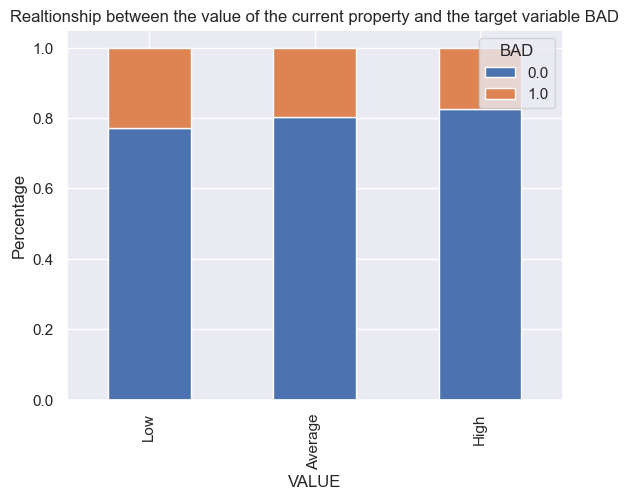

In [19]:
bins = [0, 68000, 120000, 860000]
group = ["Low", "Average", "High"]
dfWithBin["VALUE_bin"] = pd.cut(dfWithBin["VALUE"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["VALUE_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Realtionship between the value of the current property and the target variable BAD",
)
plt.xlabel("VALUE")
P = plt.ylabel("Percentage")

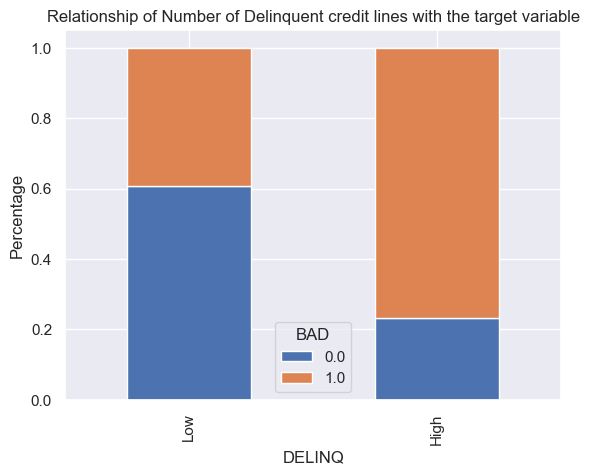

In [20]:
bins = [0, 3, 15]
group = ["Low", "High"]
dfWithBin["DELINQ_bin"] = pd.cut(dfWithBin["DELINQ"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["DELINQ_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Relationship of Number of Delinquent credit lines with the target variable",
)
plt.xlabel("DELINQ")
P = plt.ylabel("Percentage")

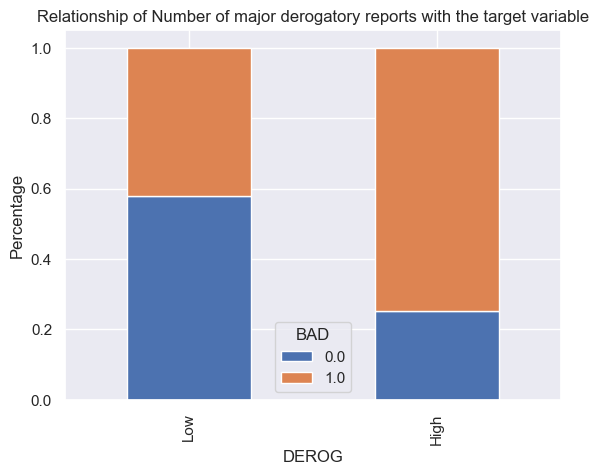

In [21]:
bins = [0, 2, 15]
group = ["Low", "High"]
dfWithBin["DEROG_bin"] = pd.cut(dfWithBin["DEROG"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["DEROG_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Relationship of Number of major derogatory reports with the target variable",
)
plt.xlabel("DEROG")
P = plt.ylabel("Percentage")

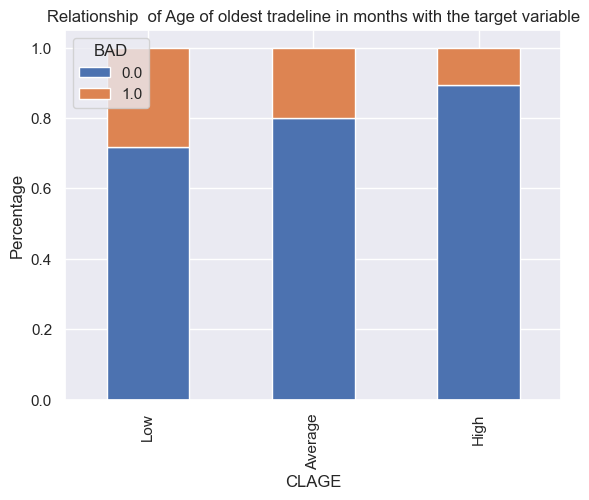

In [22]:
bins = [0, 120, 230, 1170]
group = ["Low", "Average", "High"]
dfWithBin["CLAGE_bin"] = pd.cut(dfWithBin["CLAGE"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["CLAGE_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Relationship  of Age of oldest tradeline in months with the target variable",
)
plt.xlabel("CLAGE")
P = plt.ylabel("Percentage")

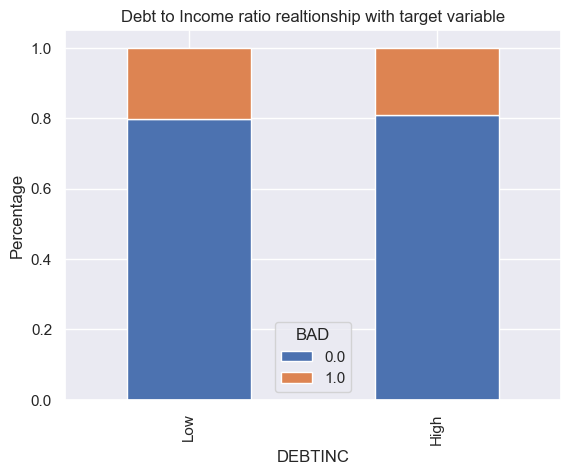

In [23]:
bins = [0, 40, 204]
group = ["Low", "High"]
dfWithBin["DEBTINC_bin"] = pd.cut(dfWithBin["DEBTINC"], bins, labels=group)
LOAN_bin = pd.crosstab(dfWithBin["DEBTINC_bin"], dfWithBin["BAD"])
LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(
    kind="bar",
    stacked=True,
    title="Debt to Income ratio realtionship with target variable",
)
plt.xlabel("DEBTINC")
P = plt.ylabel("Percentage")



These stacked bar plots show:

    The proportion of defaulters or non defaulters in each category of categorical variables
    The proportion for defaulters having Sales job is higher
    There is nothing significant that we can infer from the number of defaulters having a different reason for taking out loan


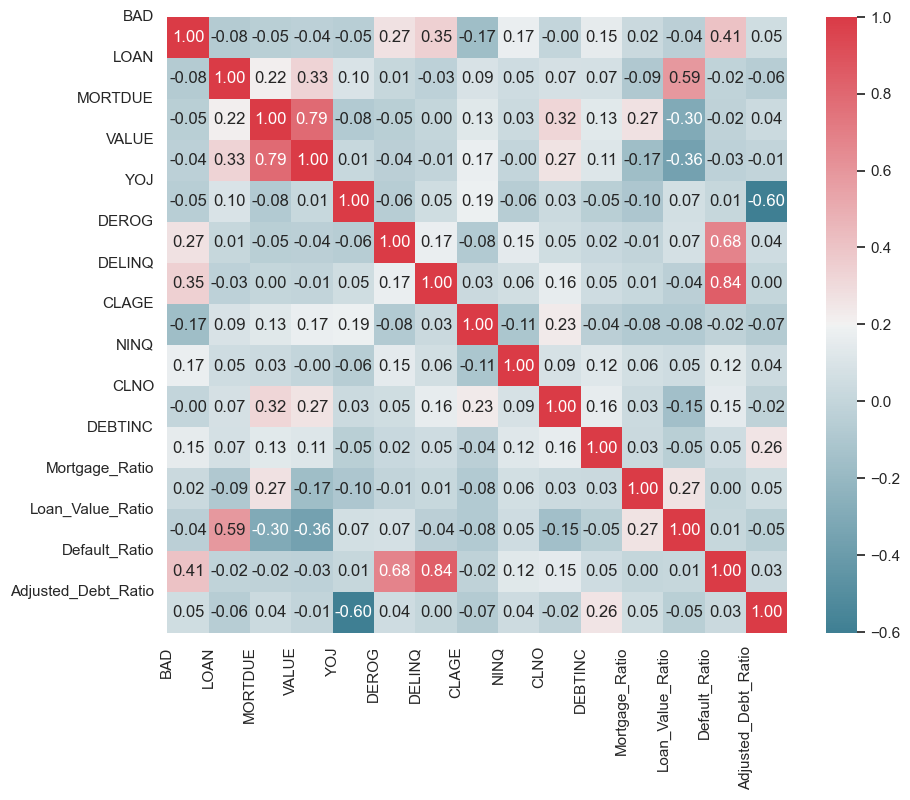

In [24]:
# Create Correlation matrix
df_cleaned = df.dropna()  # Remove rows with NaN
corr = df_cleaned.select_dtypes(include=[np.number]).corr()

# Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns)
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
# show plot
plt.show()


This correlation matrix shows the correlation between all the numeric variables.

The interesting correlation that we can see is that BAD (target variable) is positively correlated with DELINQ, DEROG and DEBTINC

Data Preprocessing
==

**Encoding**

As many of the Machine Learning models takes only the numerical values as input so we have to convert categorical columns to numeric
Dummy variable turns categorical variables into a series of 0 and 1, making them much easier to compare

In [25]:
# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,Mortgage_Ratio,Loan_Value_Ratio,Default_Ratio,Adjusted_Debt_Ratio,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1.0,1100.0,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,...,0.662652,0.028187,0.0,3.027675,True,False,True,False,False,False
1,1.0,1300.0,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,...,1.024167,0.019006,2.0,4.352283,True,False,True,False,False,False
2,1.0,1500.0,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,...,0.808383,0.089820,0.0,6.963652,True,False,True,False,False,False
3,1.0,1500.0,65019.0,89235.5,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.728623,0.016809,0.0,4.352283,False,False,True,False,False,False
4,0.0,1700.0,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,...,0.873214,0.015179,0.0,8.704565,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0.0,88900.0,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,...,0.634961,0.985752,0.0,2.124256,False,False,True,False,False,False
5956,0.0,89000.0,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,...,0.587237,0.957638,0.0,2.109410,False,False,True,False,False,False
5957,0.0,89200.0,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,...,0.581604,0.959924,0.0,2.222287,False,False,True,False,False,False
5958,0.0,89800.0,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,...,0.548328,0.977564,0.0,2.289392,False,False,True,False,False,False


 We can use scikit-learn (sklearn) for making different models. It requires the target variable in a separate dataset 

In [26]:
# Séparation des variables explicatives et de la cible
X = df_encoded.drop(columns=["BAD"])
y = df_encoded["BAD"]

In [27]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalisation des données
# some of the columns in X have large variance in the 
# numeric data in them so standard scaling is done to normalize them
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
pd.DataFrame(X_test_scaled, columns=X_test.columns)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,Mortgage_Ratio,Loan_Value_Ratio,Default_Ratio,Adjusted_Debt_Ratio,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,0.584885,-0.746722,-0.532286,1.405239,-0.281579,-0.374235,0.053162,-0.104551,0.076961,-0.042998,-0.383892,0.824086,-0.435948,-0.646710,-0.659430,2.320100,-0.912766,-0.517118,-0.140267,-0.180227
1,0.095114,-0.936473,-0.701140,0.719653,-0.281579,-0.374235,-0.712041,-0.104551,-0.421480,0.513628,-0.467431,0.613142,-0.435948,-0.555654,-0.659430,-0.431016,1.095571,-0.517118,-0.140267,-0.180227
2,-0.670711,-0.431801,-0.632397,-0.514400,-0.281579,-0.374235,1.717684,-0.711000,-1.119297,-0.092445,0.135814,-0.295760,-0.435948,-0.225403,-0.659430,-0.431016,1.095571,-0.517118,-0.140267,-0.180227
3,-0.795380,-0.653949,-0.731038,-0.925752,-0.281579,0.535221,-1.146252,-0.711000,-0.222103,0.604139,-0.027351,-0.343003,0.248928,0.566528,-0.659430,-0.431016,1.095571,-0.517118,-0.140267,-0.180227
4,-1.294056,-0.352427,-0.566241,-0.720076,-0.281579,0.535221,-0.125319,-0.711000,-0.321791,0.112778,0.143307,-0.962860,0.248928,0.012940,1.516461,-0.431016,1.095571,-0.517118,-0.140267,-0.180227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.237593,-0.256322,0.056158,0.582536,-0.281579,-0.374235,-0.427093,-0.711000,-0.720544,0.287023,-0.354027,-0.081297,-0.435948,-0.549100,1.516461,2.320100,-0.912766,-0.517118,-0.140267,-0.180227
1188,-0.243274,-0.513987,0.996071,1.405239,-0.281579,-0.374235,0.716213,-0.711000,0.675091,-1.788691,-0.907288,-0.703932,-0.435948,-0.717086,-0.659430,-0.431016,-0.912766,1.933795,-0.140267,-0.180227
1189,-0.697426,-0.536507,-0.647754,0.034068,-0.281579,-0.374235,-1.003460,0.501897,1.273220,0.866564,0.018105,-0.310268,-0.435948,-0.389965,1.516461,-0.431016,1.095571,-0.517118,-0.140267,-0.180227
1190,0.264307,1.625145,1.467171,-0.103049,-0.281579,-0.374235,1.577344,-0.711000,-0.521168,1.433316,0.007088,-0.603882,-0.435948,-0.290285,1.516461,-0.431016,-0.912766,-0.517118,-0.140267,-0.180227


In [29]:
y

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
5955    0.0
5956    0.0
5957    0.0
5958    0.0
5959    0.0
Name: BAD, Length: 5960, dtype: float64

Performance/Evaluation metrics of the models
==

**Confusion Matrix**

A confusion matrix is a summary of prediction results on a classification problem. A confusion matrix for binary classification shows the four different outcomes: true positive, false positive, true negative, and false negative. The actual values form the columns, and the predicted values (labels) form the rows.

![image.png](image.png)

**Accuracy**

•	True Positive - Targets which are actually true(Y) and we also predicted them true(Y)
•	True Negative - Targets which are actually false(N) and we also predicted them false(N)
•	False Positive - Targets which are actually false(N) but we predicted them true(T)
•	False Negative - Targets which are actually true(T) but we predicted them false(N)
We can calculate the accuracy of the model using these values of confusion matrix. The accuracy is given by:

Accuracy= TP + TN / (TP + TN + FP + FN)

**Precision **

Precision is a measure of correctness achieved in true prediction i.e. it calculates out of observations labeled as true, how many of them are actually true.Precision is a good measure to determine, when the costs of False Positive is high.

Precision = TP / (TP + FP)

**Recall**

Recall is a measure of actual observations which are predicted correctly i.e. it calculates how many observations of true class are labeled correctly. It is also known as ‘Sensitivity’. Precision is a good measure to determine, when the costs of False Positive is high.

Recall = TP / (TP + FN)

**Specificity**

Specificity is a measure of how many observations of false class are labeled correctly.

Specificity = TN / (TN + FP)

Specificity and Sensitivity both plays an important role in deriving ROC curve.

**ROC curve**

Receiver Operating Characteristic(ROC) summarizes the model’s performance by calculating the trade offs between true positive rate (sensitivity) and false positive rate(1- specificity).
The area under curve (AUC) also called concordance index is a perfect performance metric for ROC curve. Higher the area under curve, better the prediction power of the model.


In [26]:

# classic_results_df = pd.DataFrame(classic_results).T
# boosting_results_df = pd.DataFrame(boosting_results).T

# print("\n=== Comparaison des Performances - Modèles Classiques ===")
# display(classic_results_df)

# print("\n=== Comparaison des Performances - Modèles Boosting ===")
# display(boosting_results_df)



=== Comparaison des Performances - Modèles Classiques ===


,Accuracy,Precision,Recall,AUC
Logistic Regression,0.842282,0.719298,0.344538,0.762288
Decision Tree,0.874161,0.705607,0.634454,0.784208
Random Forest,0.904362,0.892405,0.592437,0.962075



=== Comparaison des Performances - Modèles Boosting ===


,Accuracy,Precision,Recall,AUC
XGBoost,0.915268,0.878453,0.668067,0.951782
CatBoost,0.906040,0.862069,0.630252,0.955041


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_22884\190361256.py:44: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")


Meilleurs paramètres (Logistic Regression): {'model__C': 0.01, 'model__solver': 'liblinear'}
Meilleur score AUC: 0.8078787378648841


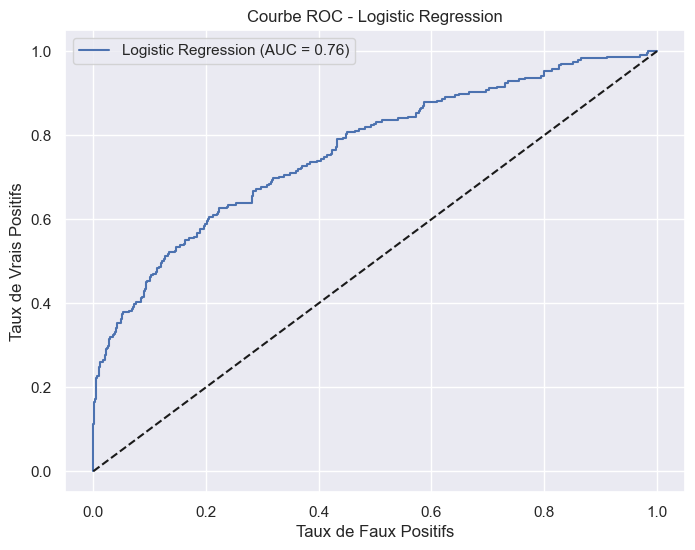

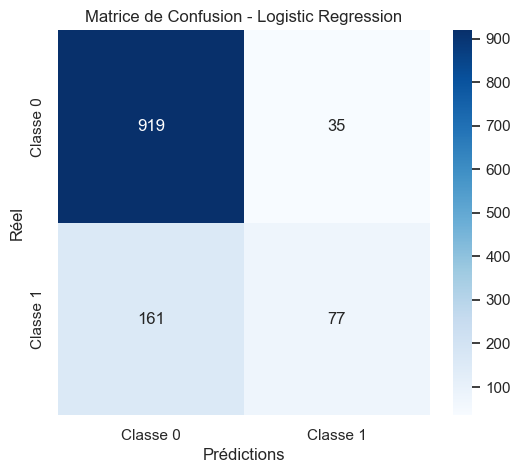


Classification Report - Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       954
         1.0       0.69      0.32      0.44       238

    accuracy                           0.84      1192
   macro avg       0.77      0.64      0.67      1192
weighted avg       0.82      0.84      0.81      1192



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Définition de la validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Paramètres pour GridSearchCV
param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__solver": ["liblinear", "lbfgs"],
}

# Pipeline RFE + Logistic Regression
pipeline_lr = Pipeline(
    [
        ("feature_selection", RFE(LogisticRegression(), n_features_to_select=10)),
        ("model", LogisticRegression(n_jobs=-1)),
    ]
)

# GridSearchCV avec validation croisée
grid_search_lr = GridSearchCV(
    pipeline_lr, param_grid_lr, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_lr.fit(X_train_scaled, y_train)

# Meilleurs paramètres et performances
print("Meilleurs paramètres (Logistic Regression):", grid_search_lr.best_params_)
print("Meilleur score AUC:", grid_search_lr.best_score_)

# Prédictions
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test_scaled)
y_probs_lr = grid_search_lr.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Logistic Regression")
plt.legend()
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Classe 0", "Classe 1"],
    yticklabels=["Classe 0", "Classe 1"],
)
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Logistic Regression")
plt.show()

# Rapport de classification
print(
    "\nClassification Report - Logistic Regression:\n",
    classification_report(y_test, y_pred_lr),
)

Meilleurs paramètres (Decision Tree): {'model__max_depth': 5, 'model__min_samples_split': 10}
Meilleur score AUC: 0.8784633623421636


C:\Users\User\AppData\Local\Temp\ipykernel_22884\3220484777.py:35: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")


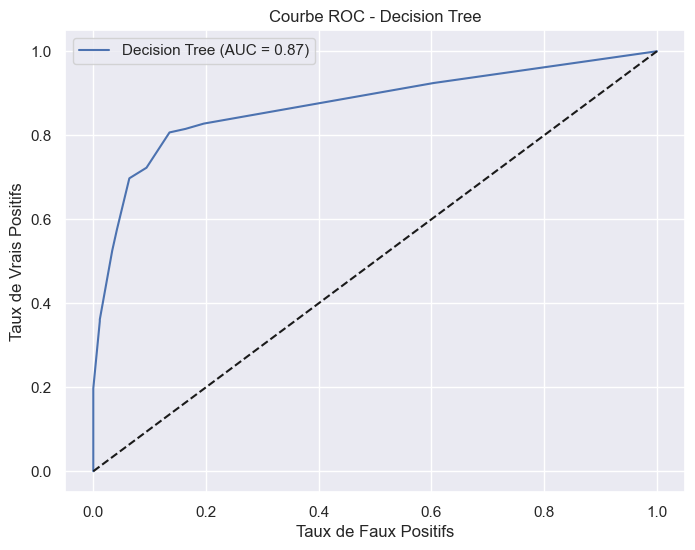

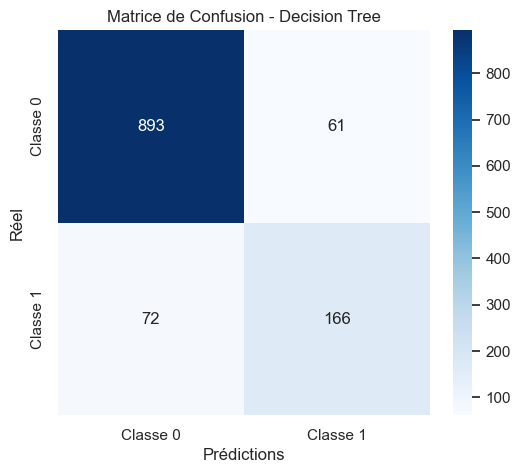


Classification Report - Decision Tree:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       954
         1.0       0.73      0.70      0.71       238

    accuracy                           0.89      1192
   macro avg       0.83      0.82      0.82      1192
weighted avg       0.89      0.89      0.89      1192



In [31]:
from sklearn.tree import DecisionTreeClassifier

# Paramètres pour GridSearchCV
param_grid_dt = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_split": [2, 5, 10],
}

# Pipeline RFE + Decision Tree
pipeline_dt = Pipeline(
    [
        ("feature_selection", RFE(DecisionTreeClassifier(), n_features_to_select=10)),
        ("model", DecisionTreeClassifier()),
    ]
)

# GridSearchCV avec validation croisée
grid_search_dt = GridSearchCV(
    pipeline_dt, param_grid_dt, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_dt.fit(X_train_scaled, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres (Decision Tree):", grid_search_dt.best_params_)
print("Meilleur score AUC:", grid_search_dt.best_score_)

# Prédictions
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test_scaled)
y_probs_dt = grid_search_dt.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Decision Tree")
plt.legend()
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Classe 0", "Classe 1"],
    yticklabels=["Classe 0", "Classe 1"],
)
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Decision Tree")
plt.show()

# Rapport de classification
print(
    "\nClassification Report - Decision Tree:\n",
    classification_report(y_test, y_pred_dt),
)

Meilleurs paramètres (Random Forest): {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Meilleur score AUC: 0.95254563410303


C:\Users\User\AppData\Local\Temp\ipykernel_22884\1150471465.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")


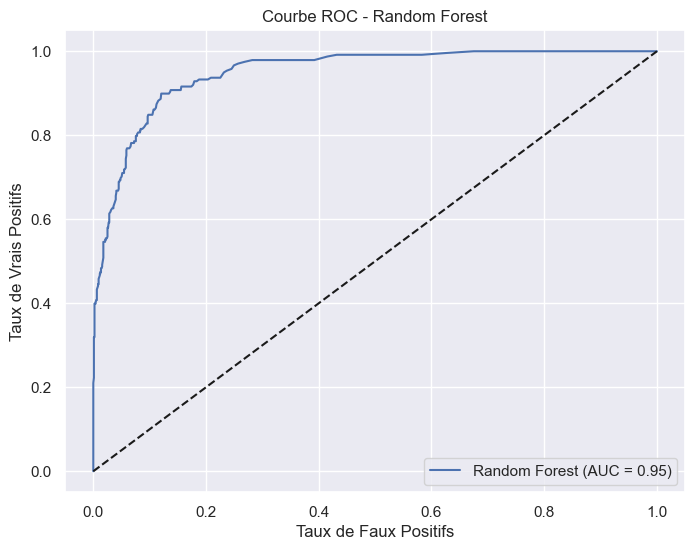

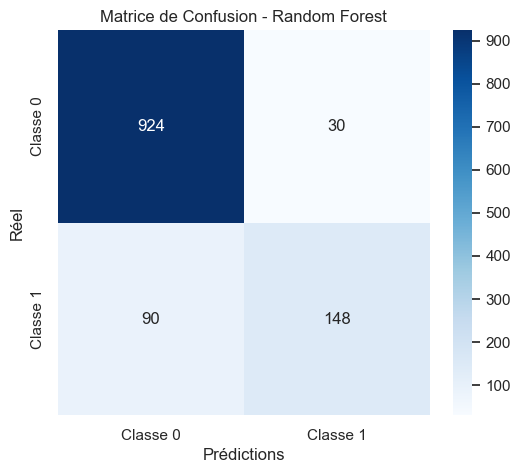


Classification Report - Random Forest:
               precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       954
         1.0       0.83      0.62      0.71       238

    accuracy                           0.90      1192
   macro avg       0.87      0.80      0.83      1192
weighted avg       0.90      0.90      0.89      1192



In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Paramètres pour GridSearchCV
param_grid_rf = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
}

# Pipeline RFE + Random Forest
pipeline_rf = Pipeline(
    [
        (
            "feature_selection",
            RFE(RandomForestClassifier(n_jobs=-1), n_features_to_select=10),
        ),
        ("model", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ]
)

# Définir la validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV avec validation croisée
grid_search_rf = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_rf.fit(X_train_scaled, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres (Random Forest):", grid_search_rf.best_params_)
print("Meilleur score AUC:", grid_search_rf.best_score_)

# Prédictions
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_scaled)
y_probs_rf = grid_search_rf.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Random Forest")
plt.legend()
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Classe 0", "Classe 1"],
    yticklabels=["Classe 0", "Classe 1"],
)
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Random Forest")
plt.show()

# Rapport de classification
print(
    "\nClassification Report - Random Forest:\n",
    classification_report(y_test, y_pred_rf),
)

# Importance des variables
# Convertir X_train_scaled en DataFrame si ce n'est déjà fait
if isinstance(X_train_scaled, np.ndarray):
    X_train_scaled = pd.DataFrame(
        X_train_scaled, columns=X.columns
    )  # Remplacez `feature_columns` par les noms des features

# Récupérer l'importance des variables et les features sélectionnées
feature_importances = grid_search_rf.best_estimator_.named_steps[
    "model"
].feature_importances_
selected_features = X_train_scaled.columns[
    grid_search_rf.best_estimator_.named_steps["feature_selection"].support_
]


Feature Importance
==
* Tree methods mathematically determine the splits which effectively helps in distinguishing the classes
* feature_importances_ is an inbuilt attribute that comes with Tree Based Classifiers
* returns an array of scores of each feature’s importance in determining the splits
* the higher the score more important is the feature towards the target variable


C:\Users\User\AppData\Local\Temp\ipykernel_22884\2434647004.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=selected_features, palette="viridis")


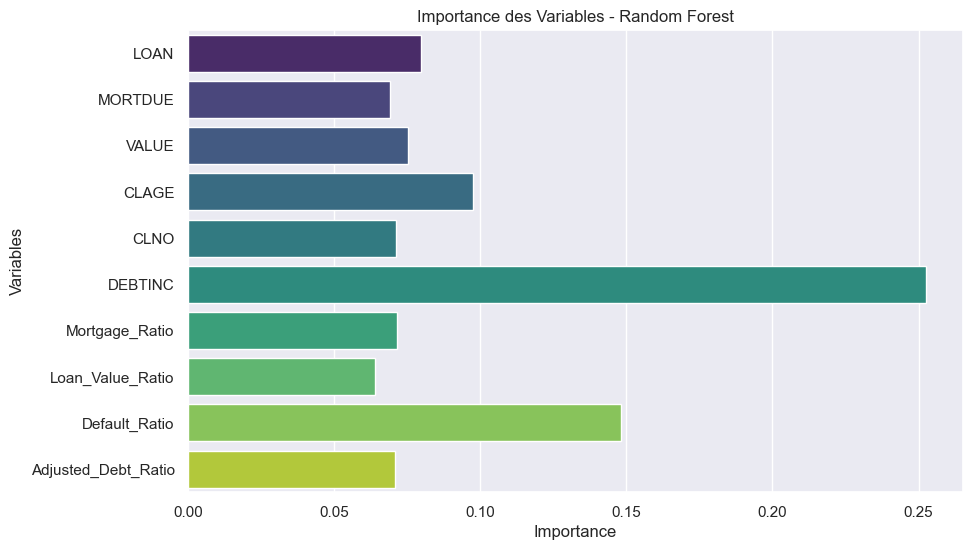

In [34]:
# Graphique de l'importance des variables
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=selected_features, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Importance des Variables - Random Forest")
plt.show()

Meilleurs paramètres (KNN): {'model__metric': 'manhattan', 'model__n_neighbors': 10, 'model__weights': 'distance'}
Meilleur score AUC: 0.9325628266834048


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_22884\916063468.py:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")


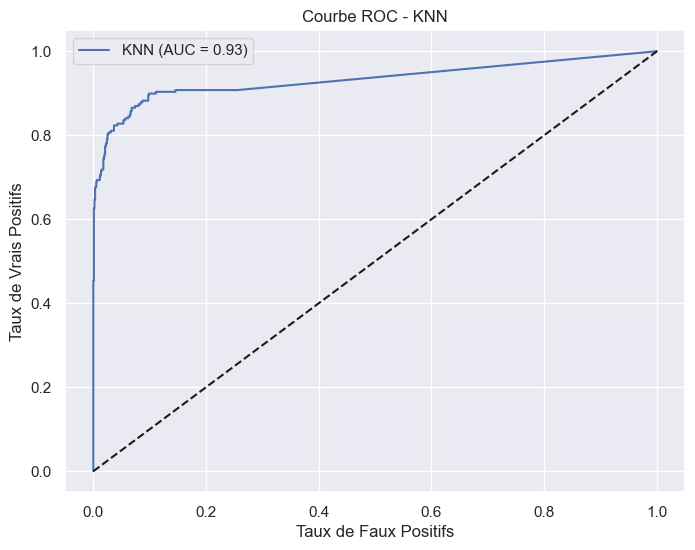

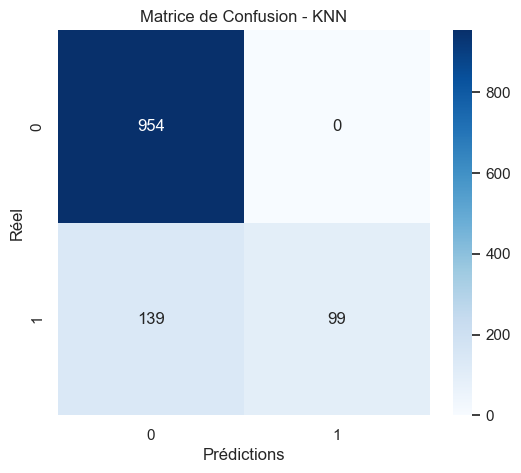

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Paramètres pour GridSearchCV
param_grid_knn = {
    "model__n_neighbors": [3, 5, 7, 10],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan"],
}

# Pipeline KNN
pipeline_knn = Pipeline([("model", KNeighborsClassifier(n_jobs=-1))])

# GridSearchCV avec validation croisée
grid_search_knn = GridSearchCV(
    pipeline_knn, param_grid_knn, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_knn.fit(X_train_scaled, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres (KNN):", grid_search_knn.best_params_)
print("Meilleur score AUC:", grid_search_knn.best_score_)

# Prédictions
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test_scaled)
y_probs_knn = grid_search_knn.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - KNN")
plt.legend()
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - KNN")
plt.show()

Meilleurs paramètres (SVC): {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Meilleur score AUC: 0.9029871264211732


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_22884\761663956.py:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")


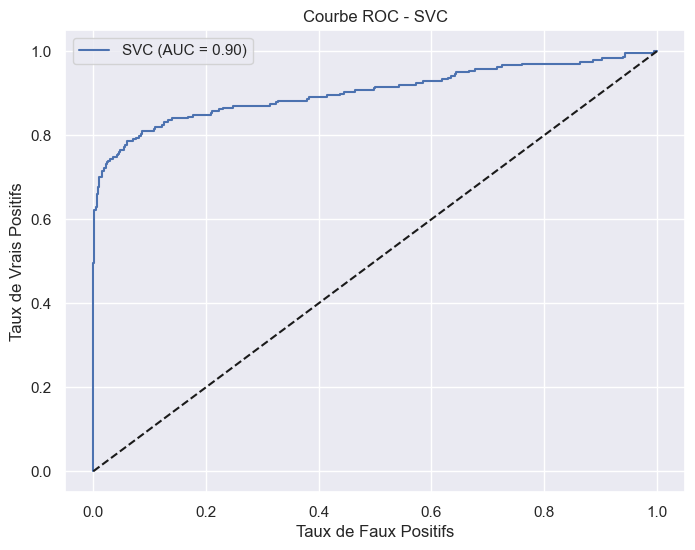

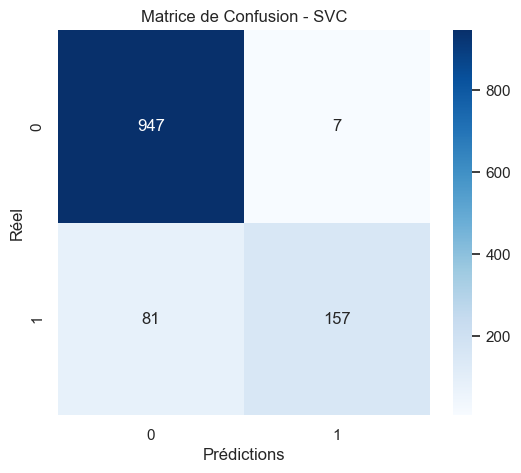

In [36]:
from sklearn.svm import SVC

# Paramètres pour GridSearchCV
param_grid_svc = {
    "model__C": [0.1, 1, 10, 100],
    "model__kernel": ["linear", "rbf"],
    "model__gamma": ["scale", "auto"],
}

# Pipeline SVC
pipeline_svc = Pipeline([("model", SVC(probability=True))])

# GridSearchCV avec validation croisée
grid_search_svc = GridSearchCV(
    pipeline_svc, param_grid_svc, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_svc.fit(X_train_scaled, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres (SVC):", grid_search_svc.best_params_)
print("Meilleur score AUC:", grid_search_svc.best_score_)

# Prédictions
y_pred_svc = grid_search_svc.best_estimator_.predict(X_test_scaled)
y_probs_svc = grid_search_svc.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_svc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVC (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - SVC")
plt.legend()
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - SVC")
plt.show()

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:17:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres (XGBoost): {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 200}
Meilleur score AUC: 0.9583060947435594


C:\Users\User\AppData\Local\Temp\ipykernel_22884\1936650522.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")


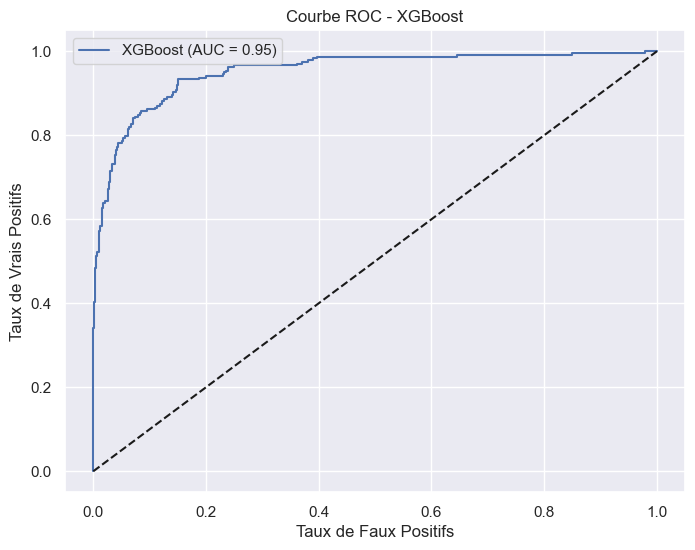

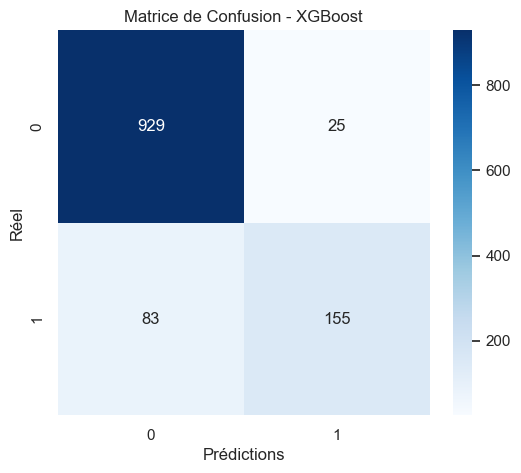

In [37]:
from xgboost import XGBClassifier

# Paramètres pour GridSearchCV
param_grid_xgb = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 6, 9],
    "model__learning_rate": [0.01, 0.1, 0.2],
}

# Pipeline XGBoost
pipeline_xgb = Pipeline(
    [
        (
            "model",
            XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_jobs=-1),
        )
    ]
)

# GridSearchCV avec validation croisée
grid_search_xgb = GridSearchCV(
    pipeline_xgb, param_grid_xgb, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_xgb.fit(X_train_scaled, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres (XGBoost):", grid_search_xgb.best_params_)
print("Meilleur score AUC:", grid_search_xgb.best_score_)

# Prédictions
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test_scaled)
y_probs_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - XGBoost")
plt.legend()
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - XGBoost")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Paramètres pour GridSearchCV
param_grid_rf = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
}

# Pipeline RFE + Random Forest
pipeline_rf = Pipeline(
    [
        (
            "feature_selection",
            RFE(RandomForestClassifier(n_jobs=-1), n_features_to_select=10),
        ),
        ("model", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ]
)

# GridSearchCV avec validation croisée
grid_search_rf = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=kf, scoring="roc_auc", n_jobs=-1
)
grid_search_rf.fit(X_train_scaled, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres (Random Forest):", grid_search_rf.best_params_)
print("Meilleur score AUC:", grid_search_rf.best_score_)

# Prédictions
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_scaled)
y_probs_rf = grid_search_rf.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--", linestyle="dashed")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Random Forest")
plt.legend()
plt.show()

# Importance des variables
feature_importances = grid_search_rf.best_estimator_.named_steps[
    "model"
].feature_importances_
selected_features = X_train_scaled.columns[
    grid_search_rf.best_estimator_.named_steps["feature_selection"].support_
]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=selected_features, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Importance des Variables - Random Forest")
plt.show()

Model Comparison on Evaluation Metrics
==

**Model**|**Accuracy**|**Precision**|**Recall **
---|---|---|---
**Logistic Regression**|0.906064209274673|0.8944531696173614|0.5801866256457886
**KNN**|0.9402497027348394|0.9430006397421091|0.6740208877284595
**SVC**|0.9354934601664685|0.9669308137762878|0.6383333333333333
**Random Forest**|0.9925683709869203|0.9583333333333333|0.9959533829718356
**Decision Tree** |0.9268727705112961|0.59|0.9628398791540785







As we can see that the accuracy is above 90% in all the models which gives the impression that all these models are best in predicting the outcome of loan. This is because the target variable is a bit unbalanced(skewed) as zeros are about 80% and ones are about 20%. Hence it is important to consider other performance metrics,such as precision and recall, to evaluate the model.
In this problem False Negative (FN) means that we predicted that a person would not default whereas that person would default. So, it is important to reduce the number of FNs otherwise the models would end up allowing loans for people who are likely to default. On the other hand, False Positive (FP) mean that the model predicts a person to be default who may not default. This is not a major problem as at the end of the day the lender will still be protected from the risk of losing capital. In summary, for this problem we need to reduce the number of FN and to achieve that we must pick a model which has a high Recall as according to the following equation high recall means less FN:

Recall = TP / (TP + FN), where TP = True Positive and FN = False Negative

From the above table, we can see that the random forest model was the most reliable compared to other models as it has the highest recall value of 0.99 and an accuracy of above 90%.


Conclusion
==

* Explored different supervised learning algorithms for classification problems such as logistic regression, KNN, SVM, Decision Tree, Random Forest
* Explored how RFE and Feature Importance gives the best contributing variables in predicting the target variable
* Explored how hyper parameter tuning is done using GridSearchCV to achieve good accuracy 
* logistic Regression produces good accuracy score of 0.906 after doing the feature selection but it did not perform well on other performance metrics(precision and recall)
* KNN  has a good accuracy score but recall score is not good
* SVM also has a good accuracy score but recall score is still bad 
* Overall analysis shows that random forest model worked very well compared to other models as it has a highest recall value of about 0.99. Hence random forest dominated over all the models in this classification problem.